# California K-12 Public Schools
## Meeting the Standards Projection

   <img src='images/shutterstock_213333985.jpeg' width="700">
   
   **Credit:**  [shutterstock](https://www.shutterstock.com/image-photo/school-books-on-desk-education-concept-213333985)


In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
import pandas_profiling

warnings.filterwarnings("ignore")  # Suppress all warnings

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 
import scipy.stats as stats
import sklearn

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_context("poster")
sns.set(style='ticks')

# Modeling
from sklearn import linear_model, preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.linear_model import Lasso

In [2]:
# load file
language = pd.read_csv('data/df_language_with_dummies')

# copy original df
language_df = language.copy()

# Drop columns not useful for modeling
language_df = language_df.drop(['School Name', 'School Code', 'Zip Code', 'County Name', 'County Code',
       'Latitude', 'Longitude'], axis=1)

# Transform percentage to 0-1
language_df[['Fluent English', 'English Learner', 'Ever-Els', 'Migrant',
       'Male', 'Female', 'Military', 'Non Military',
       'Homeless', 'Non Homeless', 'Disadvantaged', 'Not Disadvantaged',
       'Black', 'Native American', 'Asian', 'Hispanic', 'Pacific Islander',
       'White', 'Two/More Races', '< High School', 'High School Grad',
       'Some College', 'College Grad', 'Graduate School',
       'Percentage Standard Met and Above']] = language_df[['Fluent English', 'English Learner', 'Ever-Els', 'Migrant',
       'Male', 'Female', 'Military', 'Non Military',
       'Homeless', 'Non Homeless', 'Disadvantaged', 'Not Disadvantaged',
       'Black', 'Native American', 'Asian', 'Hispanic', 'Pacific Islander',
       'White', 'Two/More Races', '< High School', 'High School Grad',
       'Some College', 'College Grad', 'Graduate School',
       'Percentage Standard Met and Above']].div(100)

# Dimensions of the dataset 
print(language_df.shape)

# Overview of the data check all features are numeric
#language_df.info()

(9646, 58)


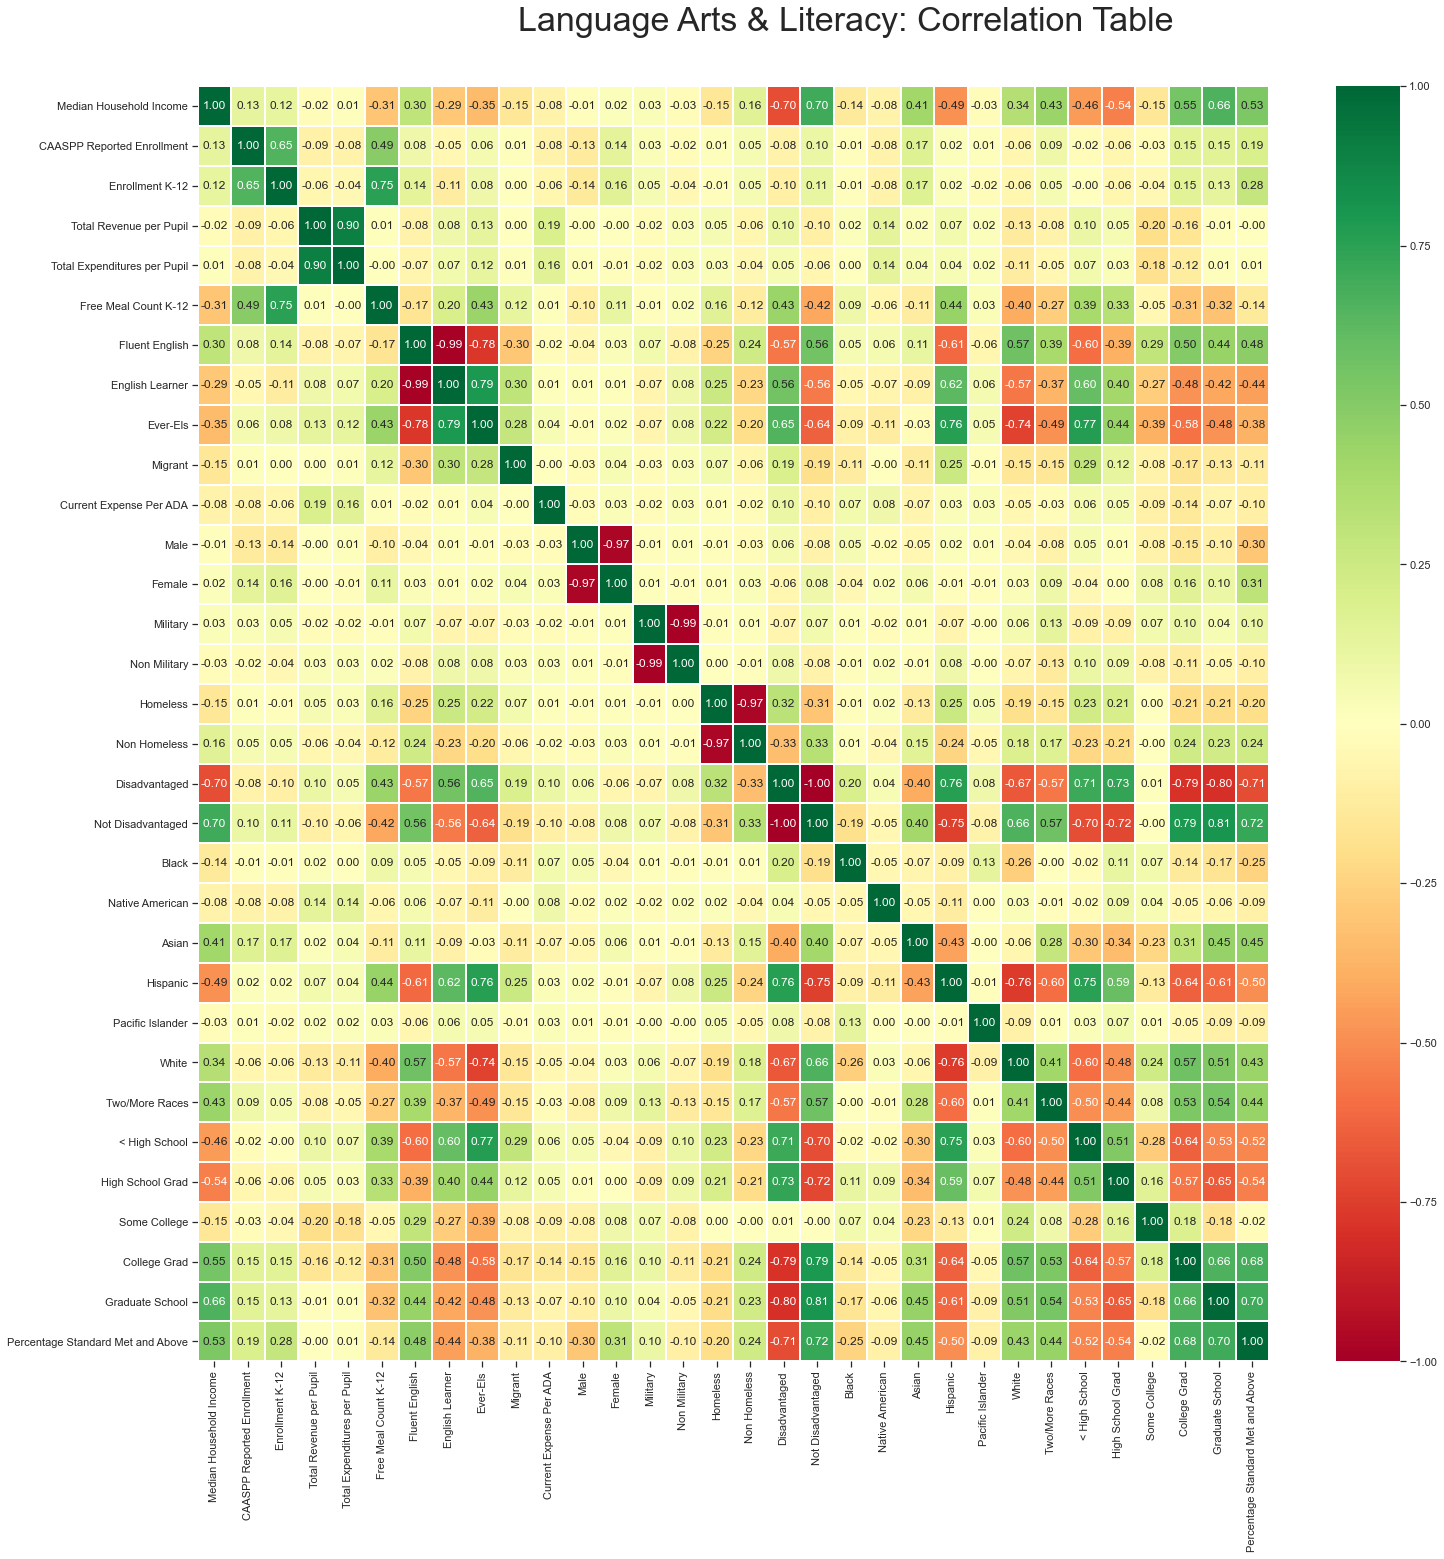

In [3]:
table = language_df[['Median Household Income', 'CAASPP Reported Enrollment','Enrollment K-12',
       'Total Revenue per Pupil','Total Expenditures per Pupil', 'Free Meal Count K-12',
       'Fluent English','English Learner', 'Ever-Els', 'Migrant',            
       'Current Expense Per ADA', 'Male', 'Female','Military', 'Non Military','Homeless','Non Homeless',
       'Disadvantaged','Not Disadvantaged', 'Black','Native American','Asian','Hispanic', 'Pacific Islander',
       'White', 'Two/More Races', '< High School', 'High School Grad', 'Some College','College Grad',
       'Graduate School','Percentage Standard Met and Above']]

# Run correlation on table constructed with count instead of percentage values
corrmat = table.corr()
f, ax = plt.subplots(figsize=(24, 22))
hm = sns.heatmap(round(corrmat,2), annot=True, cmap="RdYlGn", ax=ax, fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Language Arts & Literacy: Correlation Table', fontsize=34)

In [4]:
print(language_df['Percentage Standard Met and Above'].min())
print(language_df['Percentage Standard Met and Above'].max())

0.0
1.0


Text(0, 0.5, 'Number of schools')

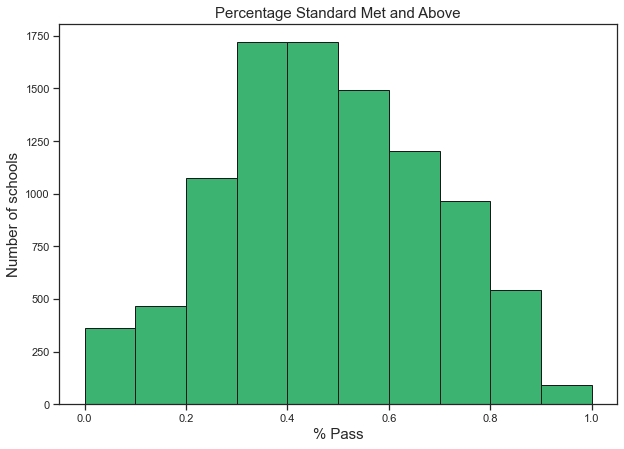

In [5]:
# distrubution of the dependent var
plt.figure(figsize=(10, 7))
plt.hist(language_df['Percentage Standard Met and Above'], color='mediumseagreen', edgecolor='k')
plt.title('Percentage Standard Met and Above', fontsize=15)
plt.xlabel('% Pass', fontsize=15)
plt.ylabel('Number of schools', fontsize=15)

## Machine Learning Models
This is a regression problem, in supervised learning. The following models were applied:

- Linear Regression
    - Sklearn and Statsmodel
    - Detect multicollinearity with VIF (Variance Inflation Factor)
- LASSO
    - Dealing with multicollinearity
- Decision Tree
- Random Forest
    - Pipeline
    - Feature importance
- Gradient Boost

### The following metrics are used to assess model performance:
   - MAE
   - MSE
   - RMSE
   - R_squared

#### Train/Test Split

In [6]:
# response variable
y = language_df['Percentage Standard Met and Above']

# keep explanatory variables correlated with response var for lr models
X = language_df.drop(['Percentage Standard Met and Above', 
       'Free Meal Count K-12', 'Male','Male-Dummy', 'Military-Dummy', 'Military', 'Non Military',
       'Non Military-Dummy', 'Total Expenditures per Pupil', 'Non Homeless',
       'Non Homeless-Dummy', 'Disadvantaged', 'Disadvantaged-Dummy', 'Not Disadvantaged',
       'Not Disadvantaged-Dummy', 'Black', 'Black-Dummy', 'Native American',
       'Native American-Dummy', 'Pacific Islander', 'Homeless', 'Homeless-Dummy',
       'Pacific Islander-Dummy',  'Some College',
       'Some College-Dummy'], axis=1)

# Split data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right
print('X_train: ', X_train.shape, 'y_train: ', y_train.shape, 'X_test :' ,X_test.shape, 'y_test: ', y_test.shape)

X_train:  (7716, 33) y_train:  (7716,) X_test : (1930, 33) y_test:  (1930,)


In [7]:
X.columns

Index(['Median Household Income', 'CAASPP Reported Enrollment',
       'CAASPP Reported Enrollment-Dummy', 'Enrollment K-12',
       'Enrollment K-12-Dummy', 'Total Revenue per Pupil',
       'Current Expense Per ADA', 'Fluent English', 'Fluent English-Dummy',
       'English Learner', 'English Learner-Dummy', 'Ever-Els',
       'Ever-Els-Dummy', 'Migrant', 'Migrant-Dummy', 'Female', 'Female-Dummy',
       'Asian', 'Asian-Dummy', 'Hispanic', 'Hispanic-Dummy', 'White',
       'White-Dummy', 'Two/More Races', 'Two/More Races-Dummy',
       '< High School', '< High School-Dummy', 'High School Grad',
       'High School Grad-Dummy', 'College Grad', 'College Grad-Dummy',
       'Graduate School', 'Graduate School-Dummy'],
      dtype='object')

------

## 1. LINEAR REGRESSION

For linear models, we're keeping only relevant variables to avoid multicollinearity. The variables were selected based on the previous correlation table and statsmodel summary table. For "paired" variables such as male/female, disadvantaged/not disadvantaged, etc -- one variable was selected if correlated with the response variable.

### 1. a. Sklearn

In [8]:
# Create linear model
rModel = linear_model.LinearRegression(normalize=True) # normalize=True parameter enables the handling of different scales

In [9]:
# Train model call .fit() method of rModel
rModel.fit(X_train, y_train)

LinearRegression(normalize=True)

In [10]:
# Predict on both x train and x test
y_tr_pred = rModel.predict(X_train)
y_te_pred = rModel.predict(X_test)

In [11]:
# Evaluate the model call .score() on rModel with parameters X_train, y_train
print(rModel.score(X_train, y_train).round(4), rModel.score(X_test, y_test).round(4))

0.7245 0.7403


In [12]:
# MAE
mae_tr_lr = mean_absolute_error(y_train, y_tr_pred).round(4) 
mae_te_lr = mean_absolute_error(y_test, y_te_pred).round(4)

# MSE - train, test 
mse_tr_lr = mean_squared_error(y_train, y_tr_pred).round(4)
mse_te_lr = mean_squared_error(y_test, y_te_pred).round(4)

# RMSE
rmse_tr_lr = mean_squared_error(y_train, y_tr_pred, squared=False).round(4)
rmse_te_lr = mean_squared_error(y_test, y_te_pred, squared=False).round(4)

#r2
r2_tr_lr = r2_score(y_train, y_tr_pred).round(4)
r2_te_lr = r2_score(y_test, y_te_pred).round(4)

print('Mean Absolute Error - train, test: ' + str(mae_tr_lr), str(mae_te_lr))
print ('Mean Squared Error - train, test: ' + str(mse_tr_lr), str(mse_te_lr))
print ('Root Mean Squared Error - train, test: ' + str(rmse_tr_lr) , str(rmse_te_lr))
print ('R-square - train, test: ' + str(r2_tr_lr), str(r2_te_lr))

Mean Absolute Error - train, test: 0.0823 0.08
Mean Squared Error - train, test: 0.0118 0.0108
Root Mean Squared Error - train, test: 0.1087 0.104
R-square - train, test: 0.7245 0.7403


Text(0, 0.5, 'Number of schools')

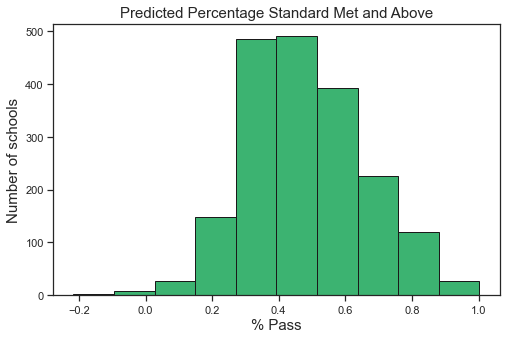

In [13]:
# distrubution of the dependent var
plt.figure(figsize=(8, 5))
plt.hist(y_te_pred, color='mediumseagreen', edgecolor='k')
plt.title('Predicted Percentage Standard Met and Above', fontsize=15)
plt.xlabel('% Pass', fontsize=15)
plt.ylabel('Number of schools', fontsize=15)

Text(0, 0.5, 'Predicted values')

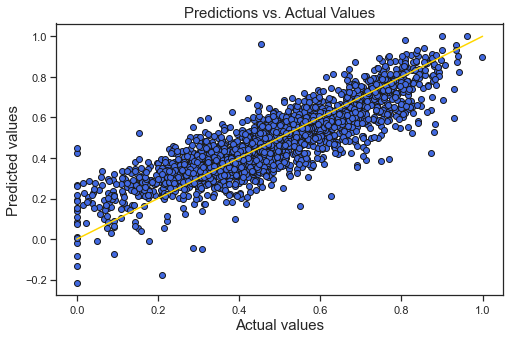

In [14]:
# Plot the predictions against the actual result
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_te_pred, color='royalblue', edgecolor='k')

# Add a line for perfect correlation
plt.plot([x for x in range(0, 2)],[x for x in range(0, 2)], color='gold')

# Label 
plt.title('Predictions vs. Actual Values', fontsize=15)
plt.xlabel('Actual values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)

------

### 1. b. Statsmodel
- Ordinary Least Square Method (OLS)

In [15]:
# Create constants for X train and test
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [16]:
# Create the model
rModel2 = sm.OLS(y_train, X_train)

# Fit the model
rModel2_results = rModel2.fit()

In [17]:
rModel2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Percentage Standard Met and Above   R-squared:                       0.724
Model:                                           OLS   Adj. R-squared:                  0.723
Method:                                Least Squares   F-statistic:                     631.3
Date:                               Mon, 21 Jun 2021   Prob (F-statistic):               0.00
Time:                                       14:45:54   Log-Likelihood:                 6174.7
No. Observations:                               7716   AIC:                        -1.228e+04
Df Residuals:                                   7683   BIC:                        -1.205e+04
Df Model:                                         32                                         
Covariance Type:                           nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Median Household Income            2.09e-07   7.14e-08      2.929      0.003    6.91e-08    3.49e-07
CAASPP Reported Enrollment       -6.078e-05   6.38e-06     -9.520      0.000   -7.33e-05   -4.83e-05
CAASPP Reported Enrollment-Dummy    -0.7622      0.071    -10.787      0.000      -0.901      -0.624
Enrollment K-12                   4.882e-05   3.27e-06     14.932      0.000    4.24e-05    5.52e-05
Enrollment K-12-Dummy                0.0559      0.017      3.269      0.001       0.022       0.089
Total Revenue per Pupil           4.272e-06   3.99e-07     10.703      0.000    3.49e-06    5.05e-06
Current Expense Per ADA          -7.799e-07   2.71e-07     -2.879      0.004   -1.31e-06   -2.49e-07
Fluent English                       0.7924      0.076     10.373      0.000       0.643       0.942
Fluent English-Dummy                -0.1162      0.043     -2.727      0.006      -0.200      -0.033
English Learner                      0.4211      0.076      5.516      0.000       0.271       0.571
English Learner-Dummy               -0.0179      0.006     -2.789      0.005      -0.030      -0.005
Ever-Els                             0.1628      0.014     11.650      0.000       0.135       0.190
Ever-Els-Dummy                       0.0281      0.009      3.255      0.001       0.011       0.045
Migrant                              0.4803      0.067      7.206      0.000       0.350       0.611
Migrant-Dummy                       -0.0242      0.005     -4.692      0.000      -0.034      -0.014
Female                               0.5042      0.022     22.959      0.000       0.461       0.547
Female-Dummy                        -0.0870      0.017     -5.088      0.000      -0.121      -0.053
Asian                                0.5100      0.018     28.431      0.000       0.475       0.545
Asian-Dummy                          0.0226      0.003      6.551      0.000       0.016       0.029
Hispanic                             0.3241      0.013     24.040      0.000       0.298       0.351
Hispanic-Dummy                      -0.0531      0.012     -4.346      0.000      -0.077      -0.029
White                                0.3259      0.013     25.403      0.000       0.301       0.351
White-Dummy                         -0.0337      0.005     -7.295      0.000      -0.043      -0.025
Two/More Races                       0.3830      0.047      8.204      0.000       0.291       0.475
Two/More Races-Dummy                -0.0162      0.004     -3.769      0.000      -0.025      -0.008
< High School                       -0.2290      0.017    -13.857      0.000      -0.261  

In [18]:
# Make predictions of the dependent variable y. Use predict(), and plug in X_test as the parameter
y_te_pred = rModel2_results.predict(X_test)
y_tr_pred = rModel2_results.predict(X_train)

In [19]:
# MAE
median_mae = mean_absolute_error(y_train, y_tr_pred).round(4), mean_absolute_error(y_test, y_te_pred).round(4)
# MSE - train, test 
median_mse = mean_squared_error(y_train, y_tr_pred).round(4), mean_squared_error(y_test, y_te_pred).round(4)
# RMSE
median_rmse = mean_squared_error(y_train, y_tr_pred, squared=False).round(4), mean_squared_error(y_test, y_te_pred, squared=False).round(4)
#r2
median_r2 = r2_score(y_train, y_tr_pred).round(4), r2_score(y_test, y_te_pred).round(4)

print ('Mean Absolute Error - train, test: ' + str(median_mae))
print ('Mean Squared Error - train, test: ' + str(median_mse))
print ('Root Mean Squared Error - train, test: ' + str(median_rmse))
print ('R-square - train, test: ' + str(median_r2))

Mean Absolute Error - train, test: (0.0823, 0.08)
Mean Squared Error - train, test: (0.0118, 0.0108)
Root Mean Squared Error - train, test: (0.1087, 0.104)
R-square - train, test: (0.7245, 0.7403)


Text(0, 0.5, 'Predicted values')

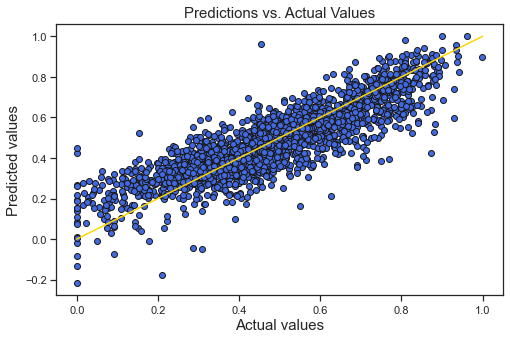

In [20]:
# Plot the predictions
# Build a scatterplot
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_te_pred, color='royalblue', edgecolor='k')

# Add a line for perfect correlation. Can you see what this line is doing? 
plt.plot([x for x in range(0,2)],[x for x in range(0,2)], color='gold')

# Label 
plt.title('Predictions vs. Actual Values', fontsize=15)
plt.xlabel('Actual values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)

There are signs of multicollinearity in the analysis. For instance, the variable disadvantaged is highly correlated with the response variable but appears with not a significant coefficient in the regression analysis. Median houselhold income also has a positive correlation with the response variable and the coefficient sign is not logical. There are also variables with high pairwise relationship. In the following examples, the modeling addresses these issues.

The existence of multicollinearity in the dataset can result in an increase of the variance of regression coefficients leading to unstable estimation of parameter values. This in turn can lead to erroneous identification of relevant predictors within a regression and detracts from a model’s ability to extrapolate beyond the range of the sample it was constructed with. That is, overfitting is a side effect of multicollinearity.

-------------------

## 1. c. Detecting Multicollinearity with VIF


**The Variance Inflation Factor (VIF)**

The Variance Inflation Factor (VIF) measures the impact of collinearity among the variables in a regression model. The Variance Inflation Factor (VIF) is 1/Tolerance, it is always greater than or equal to 1. There is no formal VIF value for determining presence of multicollinearity. Values of VIF that exceed 10 are often regarded as indicating multicollinearity, but in weaker models values above 2.5 may be a cause for concern.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = language_df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(language_df.values, i) for i in range(len(language_df.columns))]
  
print(vif_data)

                              feature         VIF
0             Median Household Income    2.450696
1          CAASPP Reported Enrollment    2.458694
2    CAASPP Reported Enrollment-Dummy    0.000000
3                     Enrollment K-12    6.619322
4               Enrollment K-12-Dummy    1.264293
5             Total Revenue per Pupil    5.438119
6        Total Expenditures per Pupil    5.279518
7                Free Meal Count K-12    7.929771
8             Current Expense Per ADA    1.097731
9                      Fluent English   80.495211
10               Fluent English-Dummy    1.174565
11                    English Learner   83.382240
12              English Learner-Dummy    2.818908
13                           Ever-Els    8.881374
14                     Ever-Els-Dummy    2.270255
15                            Migrant    2.009666
16                      Migrant-Dummy    2.154926
17                               Male   40.826922
18                         Male-Dummy    1.374927


Note: Since this is a project in the social sciences which deals with data that usually correlates with one another, the threshold chosen for VIF is 10. Using the information provided by the pairwise correlation table, variables showing high pairwise relationship and high VIF are dropped from the model. In conclusion, VIF is very useful in highlighting multicollinearity, but it does not necessarily answer the question of which collinear feature shoud be dropped.

In [22]:
# Dropping highly correlated vars awith high vif score
X_vif = language_df.drop(['Fluent English', 'Fluent English-Dummy', 
                          'Female', 'Non Homeless', 'Non Homeless-Dummy', 'Enrollment K-12', 'Enrollment K-12-Dummy',
                          'Homeless', 'Non Homeless-Dummy','Not Disadvantaged', 'Not Disadvantaged-Dummy', 
                          'Non Military', 'Non Military-Dummy', 'White'], axis=1)

In [23]:
# Revisiting scores
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
  
print(vif_data)

                              feature          VIF
0             Median Household Income     2.333888
1          CAASPP Reported Enrollment     2.310606
2    CAASPP Reported Enrollment-Dummy  1145.142542
3             Total Revenue per Pupil     5.418828
4        Total Expenditures per Pupil     5.259617
5                Free Meal Count K-12     2.413810
6             Current Expense Per ADA     1.091901
7                     English Learner     3.864173
8               English Learner-Dummy     2.263475
9                            Ever-Els     8.708786
10                     Ever-Els-Dummy     2.217512
11                            Migrant     2.003378
12                      Migrant-Dummy     2.152645
13                               Male     1.701389
14                         Male-Dummy     1.180025
15                       Female-Dummy     1.460845
16                           Military     1.341566
17                     Military-Dummy     1.469325
18                     Homeless

-------

### 1. d. Re-run regression model adjusted for VIF scores

In [24]:
X = X_vif.drop(['Percentage Standard Met and Above'], axis=1)

In [25]:
# Split data into test and training
X_train_vif, X_test_vif, y_train_vif, y_test_vif = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Create linear model
rModel_vif = linear_model.LinearRegression()

# Train model call .fit() method of rModel
rModel_vif.fit(X_train_vif, y_train_vif)

# Predict on both x train and x test
y_tr_pred_vif = rModel_vif.predict(X_train_vif)
y_te_pred_vif = rModel_vif.predict(X_test_vif)

In [26]:
# Evaluate the model call .score() on rModel with parameters X_train, y_train
# MAE
median_mae = mean_absolute_error(y_train_vif, y_tr_pred_vif).round(4), mean_absolute_error(y_test_vif, y_te_pred_vif).round(4)
# MSE - train, test 
median_mse = mean_squared_error(y_train_vif, y_tr_pred_vif).round(4), mean_squared_error(y_test_vif, y_te_pred_vif).round(4)
# RMSE
median_rmse = mean_squared_error(y_train_vif, y_tr_pred_vif, squared=False).round(4), mean_squared_error(y_test_vif, y_te_pred_vif, squared=False).round(4)

print ('Mean Absolute Error - train, test: ' + str(median_mae))
print ('Mean Squared Error - train, test: ' + str(median_mse))
print ('Root Mean Squared Error - train, test: ' + str(median_rmse))
print ('R-square - train, test: ' + str(median_r2))

Mean Absolute Error - train, test: (0.0827, 0.0799)
Mean Squared Error - train, test: (0.0118, 0.0109)
Root Mean Squared Error - train, test: (0.1088, 0.1043)
R-square - train, test: (0.7245, 0.7403)


**Observation**: The evaluation metrics show that there is basically no improvement in the regression model. Let's try different models that are better "equipped" to handle highly correlated data.

-------

# 2. LASSO

LASSO is a regularization method with the capability of "selecting" variables by penalizing the high value coefficiients. In other word, lasso performs feature selection by shrinking some coefficients to zero, allowing the model to select a small number of variables as the final predictors. It uses L1 norm.

In [27]:
# response variable
y = language_df['Percentage Standard Met and Above']

# keep explanatory variables correlated with response var for lr models
X = language_df.drop(['Percentage Standard Met and Above', 
       'Free Meal Count K-12', 'Male','Male-Dummy', 'Military-Dummy', 'Military', 'Non Military',
       'Non Military-Dummy', 'Total Expenditures per Pupil', 'Non Homeless',
       'Non Homeless-Dummy', 'Disadvantaged', 'Disadvantaged-Dummy', 'Not Disadvantaged',
       'Not Disadvantaged-Dummy', 'Black', 'Black-Dummy', 'Native American',
       'Native American-Dummy', 'Pacific Islander', 'Homeless', 'Homeless-Dummy',
       'Pacific Islander-Dummy',  'Some College',
       'Some College-Dummy'], axis=1)

# Split data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [28]:
from numpy import arange

# define model
model = Lasso()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# define grid
grid = dict()
#grid['alpha'] = arange(0, 0.0001, 0.01, 1)
grid['alpha'] = np.logspace(-10, 1, 400)

# define search
search = GridSearchCV(estimator = model, 
                      param_grid = grid, 
                      scoring = 'neg_mean_absolute_error', 
                      cv = 3, 
                      n_jobs = -1)

# perform the search
results = search.fit(X, y)

# # summarize
# print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

# Make predictions
y_te_pred = search.predict(X_test)
y_tr_pred = search.predict(X_train)

Config: {'alpha': 1e-10}


In [29]:
# MAE
mae_tr_la = mean_absolute_error(y_train, y_tr_pred).round(4)
mae_te_la = mean_absolute_error(y_test, y_te_pred).round(4)

# MSE - train, test 
mse_tr_la = mean_squared_error(y_train, y_tr_pred).round(4)
mse_te_la = mean_squared_error(y_test, y_te_pred).round(4)

# RMSE
rmse_tr_la = mean_squared_error(y_train, y_tr_pred, squared=False).round(4)
rmse_te_la = mean_squared_error(y_test, y_te_pred, squared=False).round(4)

#r2
r2_tr_la = r2_score(y_train, y_tr_pred).round(4)
r2_te_la = r2_score(y_test, y_te_pred).round(4)

print('Mean Absolute Error - train, test: ' + str(mae_tr_la), str(mae_te_la))
print('Mean Squared Error - train, test: ' + str(mse_tr_la), str(mse_te_la))
print('Root Mean Squared Error - train, test: ' + str(rmse_tr_la), str(rmse_te_la))
print('R-square - train, test: ' + str(r2_tr_la), str(r2_te_la))

Mean Absolute Error - train, test: 0.0824 0.0797
Mean Squared Error - train, test: 0.0118 0.0107
Root Mean Squared Error - train, test: 0.1088 0.1034
R-square - train, test: 0.7242 0.7431


--------

### 2. a. LASSO Pipeline

In [30]:
features = list(X.columns)

In [31]:
from sklearn.pipeline import Pipeline

# Define pipeline
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('model', Lasso())])


In [32]:
# Run grid search for alpha
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.001,10,0.1)},
                      cv = 3, scoring="neg_mean_squared_error",verbose=1
                      )

# Fit model
search.fit(X_train,y_train)

# Best alpha
search.best_params_

# Verify feature importance
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

#print('Coefficients: ', coefficients)
#print('Number of features: ', importance)

# Make predictions
y_te_pred = search.predict(X_test)
y_tr_pred = search.predict(X_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [33]:
# MAE
median_mae = mean_absolute_error(y_train, y_tr_pred).round(4), mean_absolute_error(y_test, y_te_pred).round(4)
# MSE - train, test 
median_mse = mean_squared_error(y_train, y_tr_pred).round(4), mean_squared_error(y_test, y_te_pred).round(4)
# RMSE
median_rmse = mean_squared_error(y_train, y_tr_pred, squared=False).round(4), mean_squared_error(y_test, y_te_pred, squared=False).round(4)
#r2
median_r2 = r2_score(y_train, y_tr_pred).round(4), r2_score(y_test, y_te_pred).round(4)

print('Mean Absolute Error - train, test: ' + str(median_mae))
print('Mean Squared Error - train, test: ' + str(median_mse))
print('Root Mean Squared Error - train, test: ' + str(median_rmse))
print('R-square - train, test: ' + str(median_r2))


Mean Absolute Error - train, test: (0.0829, 0.08)
Mean Squared Error - train, test: (0.012, 0.0107)
Root Mean Squared Error - train, test: (0.1094, 0.1036)
R-square - train, test: (0.7212, 0.7422)


In [34]:
np.array(features)[importance > 0]

array(['Median Household Income', 'CAASPP Reported Enrollment',
       'Enrollment K-12', 'Enrollment K-12-Dummy',
       'Total Revenue per Pupil', 'Current Expense Per ADA',
       'Fluent English', 'Ever-Els', 'Ever-Els-Dummy', 'Migrant',
       'Migrant-Dummy', 'Female', 'Female-Dummy', 'Asian', 'Asian-Dummy',
       'Hispanic', 'Hispanic-Dummy', 'White', 'White-Dummy',
       'Two/More Races', 'Two/More Races-Dummy', '< High School',
       '< High School-Dummy', 'High School Grad',
       'High School Grad-Dummy', 'College Grad', 'College Grad-Dummy',
       'Graduate School', 'Graduate School-Dummy'], dtype='<U32')

In [35]:
np.array(features)[importance == 0]

array(['CAASPP Reported Enrollment-Dummy', 'Fluent English-Dummy',
       'English Learner', 'English Learner-Dummy'], dtype='<U32')

Text(0, 0.5, 'Predicted values')

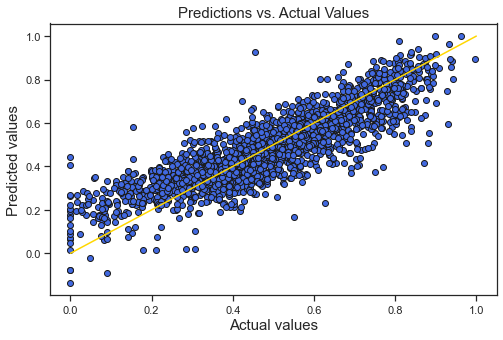

In [36]:
# Plot the predictions against the actual result
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_te_pred, color='royalblue', edgecolor='k')

# Add a line for perfect correlation
plt.plot([x for x in range(0, 2)],[x for x in range(0, 2)], color='gold')

# Label 
plt.title("Predictions vs. Actual Values", fontsize=15)
plt.xlabel("Actual values", fontsize=15)
plt.ylabel("Predicted values", fontsize=15)

--------

# 3. DECISION TREE

In [37]:
# response variable
y = language_df['Percentage Standard Met and Above']

# All columns from data in the explanatory variables X minus dummy columns
#X = language_df.drop(['Percentage Standard Met and Above'], axis=1)

X = language_df.drop(['Percentage Standard Met and Above', 
       'CAASPP Reported Enrollment-Dummy',
       'Enrollment K-12-Dummy','Fluent English-Dummy',
       'English Learner-Dummy',
       'Ever-Els-Dummy','Migrant-Dummy', 'Male-Dummy',
       'Female-Dummy', 'Military-Dummy',
       'Non Military-Dummy', 'Homeless-Dummy',
       'Non Homeless-Dummy', 'Disadvantaged-Dummy',
       'Not Disadvantaged-Dummy', 'Black-Dummy',
       'Native American-Dummy', 'Asian-Dummy',
       'Hispanic-Dummy',
       'Pacific Islander-Dummy', 'White-Dummy',
       'Two/More Races-Dummy', '< High School-Dummy',
       'High School Grad-Dummy',
       'Some College-Dummy', 'College Grad-Dummy',
       'Graduate School-Dummy'], axis=1)

# Split data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [38]:
from sklearn.tree import DecisionTreeRegressor
from random import randint
from sklearn.model_selection import RandomizedSearchCV

# Inspect hyperparameters; choose the ones to tune

# Instantiate
dt = DecisionTreeRegressor()

# Define the grid hyperparameters
param_dist = {'max_depth': [20, 30, 40],
              'min_samples_leaf': [0.01, 0.04, 0.05]}

# Instantiate a k-fold CV grid search object
dt_cv = GridSearchCV(dt, param_dist, cv=3)

# Fit model - train
dt_cv.fit(X_train, y_train)

# Predict
y_pred = dt_cv.predict(X_test)

# Extract best hyperparameters
# Extract best cv score
print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_))

# Extract best model
best_model = dt_cv.best_estimator_

Tuned Decision Tree Parameters: {'max_depth': 20, 'min_samples_leaf': 0.01}


In [39]:
# Make predictions
y_te_pred = best_model.predict(X_test)
y_tr_pred = best_model.predict(X_train)

# MAE
mae_tr_dt = mean_absolute_error(y_train, y_tr_pred).round(4)
mae_te_dt = mean_absolute_error(y_test, y_te_pred).round(4)

# MSE - train, test 
mse_tr_dt = mean_squared_error(y_train, y_tr_pred).round(4)
mse_te_dt = mean_squared_error(y_test, y_te_pred).round(4)

# RMSE
rmse_tr_dt = mean_squared_error(y_train, y_tr_pred, squared=False).round(4)
rmse_te_dt = mean_squared_error(y_test, y_te_pred, squared=False).round(4)

#r2
r2_tr_dt = r2_score(y_train, y_tr_pred).round(4)
r2_te_dt = r2_score(y_test, y_te_pred).round(4)


print ('Mean Absolute Error - train, test: ' + str(mae_tr_dt), str(mae_te_dt))
print ('Mean Squared Error - train, test: ' + str(mse_tr_dt), str(mse_te_dt))
print ('Root Mean Squared Error - train, test: ' + str(rmse_tr_dt), str(rmse_te_dt))
print ('R-square - train, test: ' + str(r2_tr_dt), str(r2_te_dt))

Mean Absolute Error - train, test: 0.0832 0.0851
Mean Squared Error - train, test: 0.0121 0.0125
Root Mean Squared Error - train, test: 0.1102 0.1118
R-square - train, test: 0.717 0.6999


Text(0, 0.5, 'Predicted values')

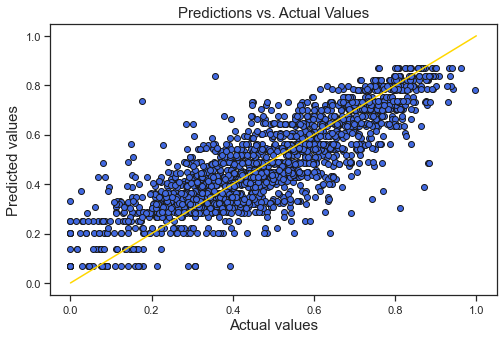

In [40]:
# Plot the predictions against the actual result
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='royalblue', edgecolor='k')

# Add a line for perfect correlation
plt.plot([x for x in range(0, 2)],[x for x in range(0, 2)], color='gold')

# Label 
plt.title("Predictions vs. Actual Values", fontsize=15)
plt.xlabel("Actual values", fontsize=15)
plt.ylabel("Predicted values", fontsize=15)

### 3. a. Tree Visualization

In [41]:
# Run dt with best features 
dt = DecisionTreeRegressor(max_depth=30, min_samples_leaf= 0.01, random_state = 42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=30, min_samples_leaf=0.01, random_state=42)

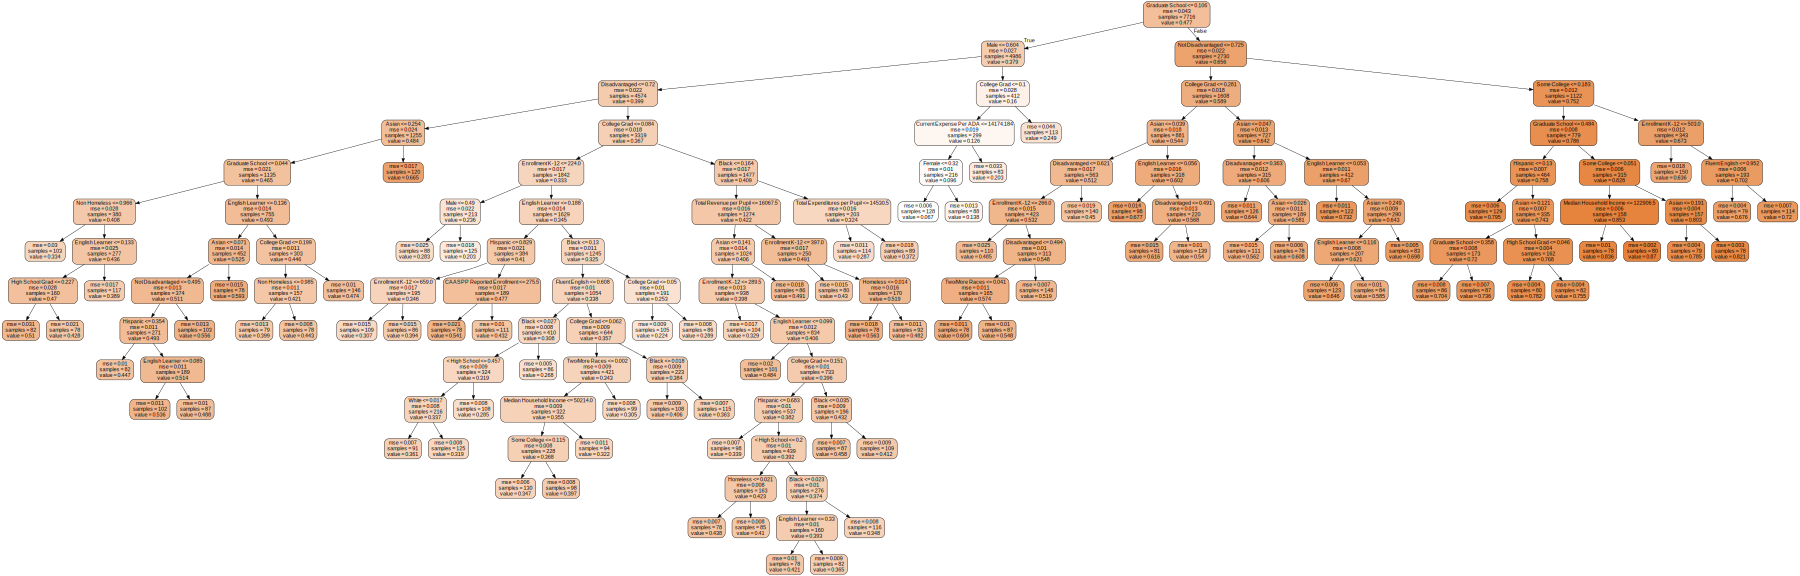

In [42]:
import graphviz
import pydotplus
from sklearn import tree

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                                 feature_names=X.columns,  
#                                 filled=True)

# graphviz.Source(dot_data, format="png") 


# Export resulting tree to DOT source code string
dot_data = tree.export_graphviz(dt, feature_names=X.columns,
                                out_file=None,
                                filled=True,
                                rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"25,25!"')
pydot_graph.write_png('resized_tree.png')

gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

### 3. b. Feature Importance

In [43]:
# create feature importance
tree_df = pd.DataFrame({'Feature Names': X.columns, 'Importance': dt.feature_importances_})
tree_df = tree_df.sort_values(by='Importance', ascending=True)
tree_df.reset_index(inplace=True)
tree_df.tail(20)

,index,Feature Names,Importance
11,15,Homeless,0.001314
12,25,Two/More Races,0.001321
13,4,Total Expenditures per Pupil,0.001497
14,26,< High School,0.001864
15,1,CAASPP Reported Enrollment,0.002304
16,6,Current Expense Per ADA,0.002893
17,7,Fluent English,0.002897
18,16,Non Homeless,0.003643
19,3,Total Revenue per Pupil,0.006124
20,22,Hispanic,0.010115


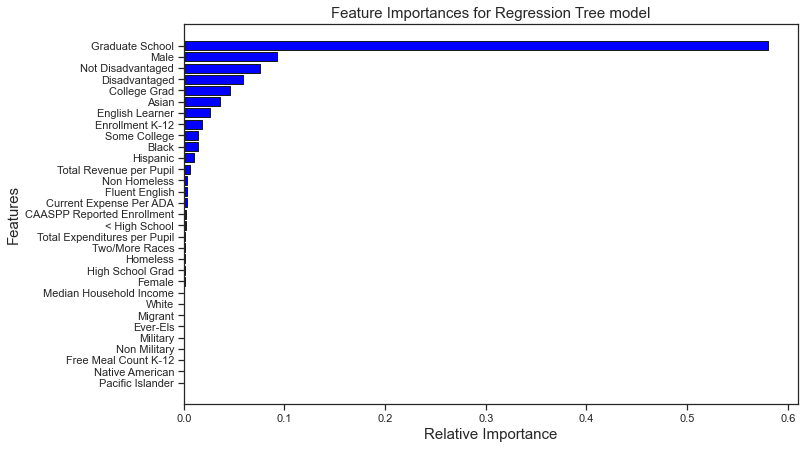

In [44]:
#Visual comparison:
plt.figure(figsize=(11,7))
_= plt.barh(tree_df['Feature Names'], tree_df['Importance'], align='center', color='blue', edgecolor='k')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for Regression Tree model', fontsize=15)
plt.show()

-------

# 4. RANDOM FOREST

In [45]:
# response variable
y = language_df['Percentage Standard Met and Above']

# All columns from data in the explanatory variables X minus dummy columns
#X = language_df.drop(['Percentage Standard Met and Above'], axis=1)

X = language_df.drop(['Percentage Standard Met and Above', 
       'CAASPP Reported Enrollment-Dummy',
       'Enrollment K-12-Dummy','Fluent English-Dummy',
       'English Learner-Dummy',
       'Ever-Els-Dummy','Migrant-Dummy', 'Male-Dummy',
       'Female-Dummy', 'Military-Dummy',
       'Non Military-Dummy', 'Homeless-Dummy',
       'Non Homeless-Dummy', 'Disadvantaged-Dummy',
       'Not Disadvantaged-Dummy', 'Black-Dummy',
       'Native American-Dummy', 'Asian-Dummy',
       'Hispanic-Dummy',
       'Pacific Islander-Dummy', 'White-Dummy',
       'Two/More Races-Dummy', '< High School-Dummy',
       'High School Grad-Dummy',
       'Some College-Dummy', 'College Grad-Dummy',
       'Graduate School-Dummy'], axis=1)

# Split data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [46]:
# Import RandomForestRegressor 
from sklearn.ensemble import RandomForestRegressor

# Set seed for reproducibility
SEED = 1

# Instantiate a random forests regressor 
rf = RandomForestRegressor(random_state = SEED)

# Print out hyperparameters
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [47]:
# Define hyperparameters
params_rf = {
        'n_estimators':[100, 350, 500],
        'max_features':['log2', 'auto', 'sqrt'],
        'min_samples_leaf':[0.01, 2, 10]}

# Instantiate a k-fold CV grid search object
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit train model
grid_rf.fit(X_train, y_train)
    
# Extract best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_model = grid_rf.best_estimator_
    

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyerparameters:
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}


In [48]:
# Make predictions
y_te_pred = best_model.predict(X_test)
y_tr_pred = best_model.predict(X_train)

# MAE
median_mae = mean_absolute_error(y_train, y_tr_pred).round(4), mean_absolute_error(y_test, y_te_pred).round(4)
# MSE - train, test 
median_mse = mean_squared_error(y_train, y_tr_pred).round(4), mean_squared_error(y_test, y_te_pred).round(4)
# RMSE
median_rmse = mean_squared_error(y_train, y_tr_pred, squared=False).round(4), mean_squared_error(y_test, y_te_pred, squared=False).round(4)
#r2
median_r2 = r2_score(y_train, y_tr_pred).round(4), r2_score(y_test, y_te_pred).round(4)

print ('Mean Absolute Error - train, test: ' + str(median_mae))
print ('Mean Squared Error - train, test: ' + str(median_mse))
print ('Root Mean Squared Error - train, test: ' + str(median_rmse))
print ('R-square - train, test: ' + str(median_r2))

Mean Absolute Error - train, test: (0.0302, 0.0702)
Mean Squared Error - train, test: (0.0018, 0.0085)
Root Mean Squared Error - train, test: (0.0424, 0.092)
R-square - train, test: (0.9582, 0.7967)


-------

### 4. a. Random Forest Pipeline

In [49]:
# RandomForestRegressor() with a random state of 42
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=SEED)
)

# 3-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=3)

# R2
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

#np.mean(rf_cv_scores), np.std(rf_cv_scores)

array([0.76445351, 0.75944683, 0.75485141])

In [50]:
# TUNING PARAMETERS
n_est = [100, 200, 300]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

# Call GridSearchCV with the random forest pipeline
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=3, n_jobs=-1)

# Fit train model
rf_grid_cv.fit(X_train, y_train)

# Best parameters
rf_grid_cv.best_params_

# Extract best model
best_model_rf = rf_grid_cv.best_estimator_

In [51]:
# Make predictions
y_te_pred = best_model_rf.predict(X_test)
y_tr_pred = best_model_rf.predict(X_train)

# MAE
mae_tr_rf = mean_absolute_error(y_train, y_tr_pred).round(4)
mae_te_rf = mean_absolute_error(y_test, y_te_pred).round(4)

# MSE - train, test 
mse_tr_rf = mean_squared_error(y_train, y_tr_pred).round(4)
mse_te_rf = mean_squared_error(y_test, y_te_pred).round(4)

# RMSE
rmse_tr_rf = mean_squared_error(y_train, y_tr_pred, squared=False).round(4)
rmse_te_rf = mean_squared_error(y_test, y_te_pred, squared=False).round(4)

#r2
r2_tr_rf = r2_score(y_train, y_tr_pred).round(4)
r2_te_rf = r2_score(y_test, y_te_pred).round(4)

print ('Mean Absolute Error - train, test: ' + str(mae_tr_rf), str(mae_te_rf))
print ('Mean Squared Error - train, test: ' + str(mse_tr_rf), str(mse_te_rf))
print ('Root Mean Squared Error - train, test: ' + str(rmse_tr_rf), str(rmse_te_rf))
print ('R-square - train, test: ' + str(r2_tr_rf), str(r2_te_rf))

Mean Absolute Error - train, test: 0.0274 0.07
Mean Squared Error - train, test: 0.0014 0.0084
Root Mean Squared Error - train, test: 0.0368 0.0918
R-square - train, test: 0.9684 0.7974


**Observation:** Random Forest performs better than Linear regression as expected, but not that much better. There might be overfitting taking place in the training data. Further hyperparameter tuning may improve that.

Text(0, 0.5, 'Predicted values')

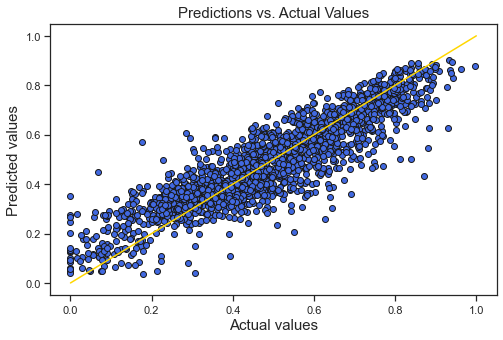

In [52]:
# Plot the predictions against the actual result
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_te_pred, color='royalblue', edgecolor='k')

# Add a line for perfect correlation
plt.plot([x for x in range(0, 2)],[x for x in range(0, 2)], color='gold')

# Label 
plt.title("Predictions vs. Actual Values", fontsize=15)
plt.xlabel("Actual values", fontsize=15)
plt.ylabel("Predicted values", fontsize=15)

-----

### 4. b. Feature Importance 

In [53]:
# create feature importance
rf_df = pd.DataFrame({'Feature Names': X.columns, 'Importance': best_model.feature_importances_})
rf_df = rf_df.sort_values(by='Importance', ascending=True)
rf_df.reset_index(inplace=True)
rf_df.tail(20)

,index,Feature Names,Importance
11,6,Current Expense Per ADA,0.011252
12,0,Median Household Income,0.011321
13,22,Hispanic,0.013107
14,26,< High School,0.013656
15,27,High School Grad,0.013734
16,24,White,0.013772
17,1,CAASPP Reported Enrollment,0.014843
18,9,Ever-Els,0.014847
19,8,English Learner,0.015597
20,28,Some College,0.018373


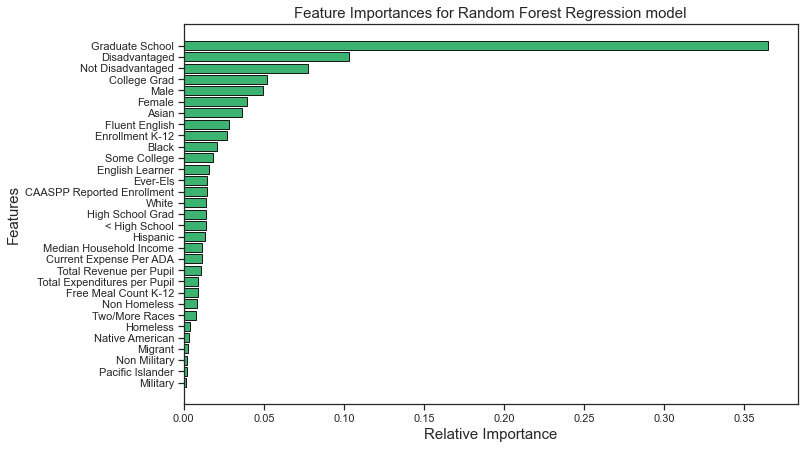

In [54]:
#Visual comparison
plt.figure(figsize=(11,7))
_= plt.barh(rf_df['Feature Names'], rf_df['Importance'], align='center', color='mediumseagreen', edgecolor='k')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for Random Forest Regression model', fontsize=15)
plt.show()

**Observation:** The most important features selected by the model to predict percentage of students passing test standards are level of education of parents (graduate and college), socioeconomic status (Disadvantaged), sex (schools with higher number of girls tend to outperform, while schools with higher number of boys tend to underperform), if they come from Asian background (Asian is highly correlated with having higher level of education), and English fluency. 

-----------

## 5. GRADIENT BOOSTING

Winner Model.

In [55]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

In [56]:
# Make predictions
y_te_pred = gb.predict(X_test)
y_tr_pred = gb.predict(X_train)

# MAE
median_mae = mean_absolute_error(y_train, y_tr_pred).round(4), mean_absolute_error(y_test, y_te_pred).round(4)
# MSE - train, test 
median_mse = mean_squared_error(y_train, y_tr_pred).round(4), mean_squared_error(y_test, y_te_pred).round(4)
# RMSE
median_rmse = mean_squared_error(y_train, y_tr_pred, squared=False).round(4), mean_squared_error(y_test, y_te_pred, squared=False).round(4)
#r2
median_r2 = r2_score(y_train, y_tr_pred).round(4), r2_score(y_test, y_te_pred).round(4)

print ('Mean Absolute Error - train, test: ' + str(median_mae))
print ('Mean Squared Error - train, test: ' + str(median_mse))
print ('Root Mean Squared Error - train, test: ' + str(median_rmse))
print ('R-square - train, test: ' + str(median_r2))

Mean Absolute Error - train, test: (0.0562, 0.0687)
Mean Squared Error - train, test: (0.0053, 0.0081)
Root Mean Squared Error - train, test: (0.0727, 0.0899)
R-square - train, test: (0.8766, 0.806)


Text(0, 0.5, 'Predicted values')

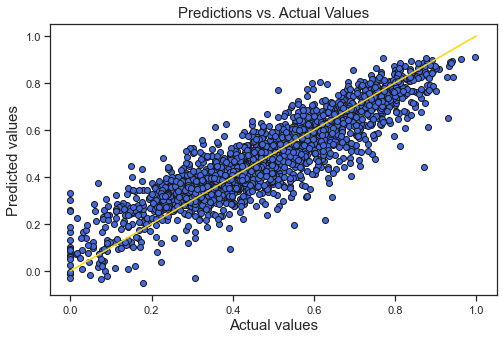

In [57]:
# Plot the predictions against the actual result
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_te_pred, color='royalblue', edgecolor='k')

# Add a line for perfect correlation
plt.plot([x for x in range(0, 2)],[x for x in range(0, 2)], color='gold')

# Label 
plt.title("Predictions vs. Actual Values", fontsize=15)
plt.xlabel("Actual values", fontsize=15)
plt.ylabel("Predicted values", fontsize=15)

------

### 5. a. Hyperparameter Tuning

In [58]:
# Set seed for reproducibility
SEED = 2

# Instantiate a random forests regressor 
gb = GradientBoostingRegressor(random_state = SEED)

# Print out hyperparameters
print(gb.get_params())

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 2, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [59]:
# Tested hyperparameters
#max_depths = np.linspace(1, 32, 32, endpoint=True)
#min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
#max_features = list(range(1, X_train.shape[1]))

# Define hyperparameters
params_gb = {'learning_rate': [0.1], 
                'n_estimators': [300], 
                'max_depth': [26],
                'max_features': [8],
                'min_samples_leaf':  [100],
                'min_samples_split': [0.1]
                }

In [60]:
# Instantiate a k-fold CV grid search object
grid_gb = GridSearchCV(estimator = gb,
                       param_grid = params_gb,
                       scoring ='neg_mean_squared_error',
                       cv = 3,
                       verbose = 1,
                       n_jobs = -1)

# Fit gb to the training set
grid_gb.fit(X_train, y_train)

# Predict test set labels
y_pred = grid_gb.predict(X_test)

# Extract best hyperparameters
best_hyperparams = grid_gb.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best model
best_model_gb = grid_gb.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best hyerparameters:
 {'learning_rate': 0.1, 'max_depth': 26, 'max_features': 8, 'min_samples_leaf': 100, 'min_samples_split': 0.1, 'n_estimators': 300}


In [61]:
# Make predictions
y_te_pred = best_model_gb.predict(X_test)
y_tr_pred = best_model_gb.predict(X_train)

# MAE
mae_tr_gb = mean_absolute_error(y_train, y_tr_pred).round(4)
mae_te_gb = mean_absolute_error(y_test, y_te_pred).round(4)

# MSE - train, test 
mse_tr_gb = mean_squared_error(y_train, y_tr_pred).round(4)
mse_te_gb = mean_squared_error(y_test, y_te_pred).round(4)

# RMSE
rmse_tr_gb = mean_squared_error(y_train, y_tr_pred, squared=False).round(4)
rmse_te_gb = mean_squared_error(y_test, y_te_pred, squared=False).round(4)

#r2
r2_tr_gb = r2_score(y_train, y_tr_pred).round(4)
r2_te_gb = r2_score(y_test, y_te_pred).round(4)

print ('Mean Absolute Error - train, test: ' + str(mae_tr_gb), str(mae_te_gb))
print ('Mean Squared Error - train, test: ' + str(mse_tr_gb), str(mse_te_gb))
print ('Root Mean Squared Error - train, test: ' + str(rmse_tr_gb), str(rmse_te_gb))
print ('R-square - train, test: ' + str(r2_tr_gb), str(r2_te_gb))

Mean Absolute Error - train, test: 0.0465 0.0669
Mean Squared Error - train, test: 0.0039 0.0077
Root Mean Squared Error - train, test: 0.0625 0.0877
R-square - train, test: 0.909 0.8152


In [ ]:
# distrubution of the dependent var
plt.figure(figsize=(8, 5))
plt.hist(y_te_pred, color='mediumseagreen', edgecolor='k')
plt.title('Predicted Percentage Standard Met and Above', fontsize=15)
plt.xlabel('% Pass', fontsize=15)
plt.ylabel('Number of schools', fontsize=15)

-----

### 5. b. Feature Importance

In [62]:
# create feature importance
gb_df = pd.DataFrame({'Feature Names': X.columns, 'Importance': best_model_gb.feature_importances_})
gb_df = gb_df.sort_values(by='Importance', ascending=True)
gb_df.reset_index(inplace=True)
gb_df.tail(20)

,index,Feature Names,Importance
11,6,Current Expense Per ADA,0.010159
12,4,Total Expenditures per Pupil,0.011463
13,28,Some College,0.012047
14,9,Ever-Els,0.012437
15,3,Total Revenue per Pupil,0.012523
16,8,English Learner,0.024087
17,19,Black,0.026399
18,7,Fluent English,0.029532
19,11,Male,0.031203
20,1,CAASPP Reported Enrollment,0.031318


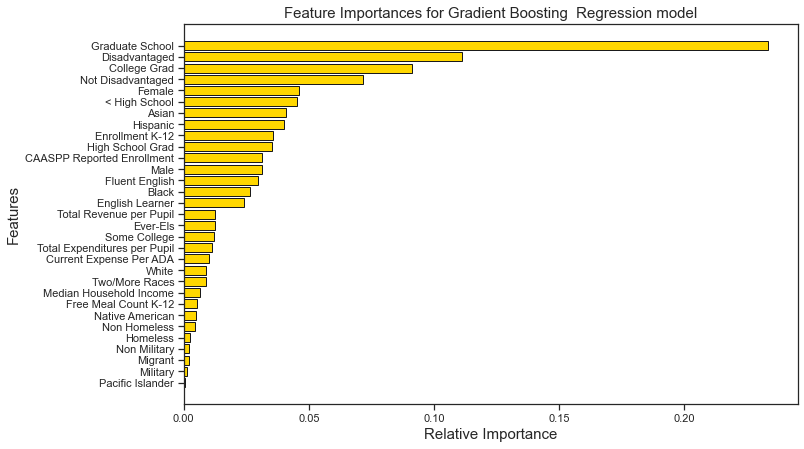

In [63]:
#Visual comparison:
plt.figure(figsize=(11,7))
_= plt.barh(gb_df['Feature Names'], gb_df['Importance'], align='center', color='gold', edgecolor='k')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for Gradient Boosting  Regression model', fontsize=15)
plt.show()

------

## 6. MODELS COMPARISON

In [64]:
# Labels
myLabels = ['Linear Regression','LASSO','Decision Tree','Random Forest','Gradient Boost']

# Comparing rmse models
score_test = [rmse_te_lr, rmse_te_la, rmse_te_dt,
             rmse_te_rf, rmse_te_gb]

score_train = [rmse_tr_lr, rmse_tr_la, rmse_tr_dt,
             rmse_tr_rf, rmse_tr_gb]
# r2
Accuracy_score_train = [r2_tr_lr, r2_tr_la, r2_tr_dt, r2_tr_rf, r2_tr_gb]
Accuracy_score_test = [r2_te_lr, r2_te_la, r2_te_dt, r2_te_rf, r2_te_gb]

# Comparing mae models
score_test1 = [mae_te_lr, mae_te_la, mae_te_dt,
             mae_te_rf, mae_te_gb]

score_train1 = [mae_tr_lr, mae_tr_la, mae_tr_dt,
             mae_tr_rf, mae_tr_gb]

# Table R2
score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score_train, Accuracy_score_test)), 
               columns =['Algorithm', 'R2 train score', 'R2 test score']) 
# Table RMSE
score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'RMSE train score', 'RMSE test score' ])
# Table MAE
score_tab1 = pd.DataFrame(list(zip(myLabels, score_train1, score_test1)), 
               columns =['Algorithm', 'MAE train score', 'MAE test score' ])

score_tab_acc

,Algorithm,R2 train score,R2 test score
0,Linear Regression,0.7245,0.7403
1,LASSO,0.7242,0.7431
2,Decision Tree,0.7170,0.6999
3,Random Forest,0.9684,0.7974
4,Gradient Boost,0.9090,0.8152


In [65]:
score_tab

,Algorithm,RMSE train score,RMSE test score
0,Linear Regression,0.1087,0.1040
1,LASSO,0.1088,0.1034
2,Decision Tree,0.1102,0.1118
3,Random Forest,0.0368,0.0918
4,Gradient Boost,0.0625,0.0877


In [66]:
 score_tab1

,Algorithm,MAE train score,MAE test score
0,Linear Regression,0.0823,0.0800
1,LASSO,0.0824,0.0797
2,Decision Tree,0.0832,0.0851
3,Random Forest,0.0274,0.0700
4,Gradient Boost,0.0465,0.0669


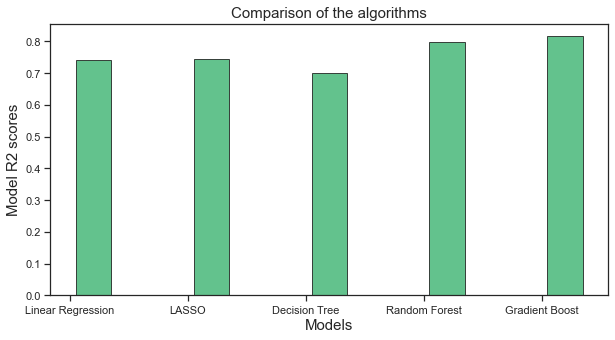

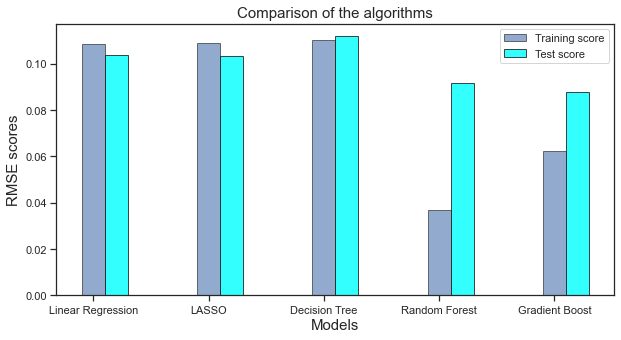

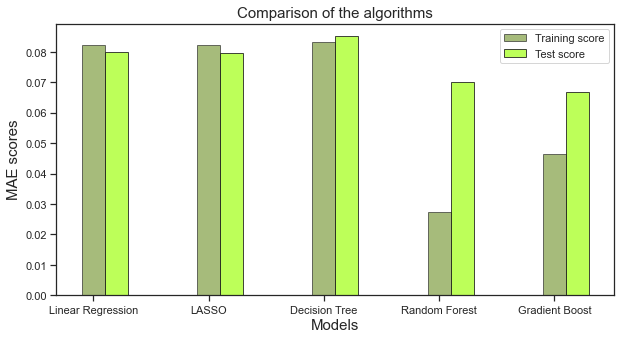

In [67]:
# plotting the R2 scores:
index = [1, 2, 3, 4, 5]
index_acc = [1.2, 2.2, 3.2, 4.2, 5.2]
plt.figure(figsize = (10, 5))
plt.xlabel('Models', fontsize=15)
plt.ylabel ('Model R2 scores', fontsize=15)
plt.title('Comparison of the algorithms', fontsize=15)
_ = plt.bar(index_acc, Accuracy_score_test, color='mediumseagreen', alpha=0.8, label='Accuracy score', edgecolor='k', width=0.3)
plt.xticks([1, 2, 3, 4, 5], myLabels)

#plt.legend()
plt.show()

# plotting and comparing RMSE train/test scores:
index=[1, 2, 3, 4, 5]
index_acc=[1.2, 2.2, 3.2, 4.2, 5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('RMSE scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index, score_train, color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc, score_test, color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2, 3, 4, 5], myLabels)
plt.legend()
plt.show()

# plotting and comparing MAE train/test scores:
index=[1, 2, 3, 4, 5]
index_acc=[1.2, 2.2, 3.2, 4.2, 5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('MAE scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index, score_train1, color='olivedrab', alpha=0.6, label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc, score_test1,color='greenyellow',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2, 3, 4, 5], myLabels)
plt.legend()
plt.show()

------

## 7. Observations

In order to predict the proportion of students passing standards in California K-12 public schools, here I have considered 31 features, either directly from the dataset or engineered/derived from the data. The most important ones in terms of relative importances are parents' level of education, students ethinicity (this might hint cultural and background differences) and socioeconomic status.

The response variable is numerical and represents a proportion of the total students per school. Here, this is treated as a Regression problem since the response variable is numerical. Nonetheless, there is no ideal model to predict proportions.

Here I have used the following Regression models:
- Linear Regression
- LASSO
- Decision (Regression) Tree
- Random Forest
- Gradient Boosting

Evaluating the performance of a model by training and testing on the same dataset can lead to the overfitting. The model evaluation is based on splitting the dataset into train and validation set. But, the performance of the prediction result depends upon the random choice of the pair of train, test set. In order to overcome that, the Cross-Validation procedure is used where under the k-fold CV approach, the training set is split into k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.

Each model is evaluated using several metrics, but mean absolute error (MAE), root-mean square error (RMSE) and R-squared (R2) were chosen to measure model accuracy. R2 was plotted for test data, and MAE  and RMSE were plotted for training and test data. The best performing model with a r-square of 81.5 was Gradient Boosting, an ensemble method based on decision treees.

<!-- ## 8. Future direction 

Regarding variables, the addition of relevant features can improve prediction. During exploratory analyses, latitude and longitude data pointed to pontential difference in the proportion of students passing the standards based on location such as rural vs city. Addition of this information to the model may improve prediction.

Also, access to the same dataset used here but at student level would enhance understanding and prediction. Further, a time-series analysis of students' performance may be informative to policy makers.

I would be curious to add variables such as climate data regarding number of sunny/rainy days, and proximity to green areas like national parks. There is research suggesting that growing near green areas is beneficial to well-being.

Regarding models, I woould like to apply logistic regression. -->


------